In [1]:
%%time
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split, KFold
from torchvision import transforms
from PIL import Image
from transformers import SegformerForSemanticSegmentation, SegformerConfig, SegformerImageProcessor
import tkinter as tk
from tkinter import filedialog
import tensorflow as tf
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score, accuracy_score
from transformers import SamModel, SamProcessor
from torch import nn
from scipy.ndimage import label, find_objects
from sklearn.model_selection import StratifiedKFold
from datetime import datetime

# DataSet
class SplashDataSet_train_val_0501(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.images_dir = os.path.join(self.root_dir, "images")
        self.masks_dir = os.path.join(self.root_dir, "annotations")
        # get filenames
        self.images_list = sorted(os.listdir(self.images_dir))
        self.masks_list = sorted(os.listdir(self.masks_dir))
        assert len(self.images_list) == len(self.masks_list), "Number of images and annotations should be the same."

        # transform image to 1024*1024
        self.transform = transforms.Compose([
            transforms.Resize((1024, 1024)),
            transforms.ToTensor(),  # This will scale pixel values to [0, 1]
        ])
    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, idx):
        # get image and annotation file
        img_path = os.path.join(self.images_dir, self.images_list[idx])
        mask_path = os.path.join(self.masks_dir, self.masks_list[idx])
        
        image = Image.open(img_path)
        mask = Image.open(mask_path)
        
        image = self.transform(image)
        mask = self.transform(mask)

        # Convert mask to binary 0 and 1
        mask = (mask > 0).to(torch.int)
        mask = mask[0, None, :, :]
        
        return image, mask

    def get_time_category(self, filename):
        # my filenames' format is 2024-04-09-03-00-11.png
        time_str = filename.split('-')[3:5]
        time_obj = datetime.strptime('-'.join(time_str), '%H-%M')
        hour = time_obj.hour
        if hour < 8:
            return 'morning'
        elif 8 <= hour <= 16:
            return 'day'
        else:
            return 'evening'

def focal_loss(inputs, targets, alpha=0.25, gamma=2.0, reduction='mean'):
    #print("inputs size = ", inputs.size())
    # inputs size =  torch.Size([1, 2, 1024, 1024])
    #print("targets size = ", targets.size())
    # targets size =  torch.Size([1, 1024, 1024])
    BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    F_loss = at * (1 - pt)**gamma * BCE_loss

    if reduction == 'mean':
        return torch.mean(F_loss), (1 - pt)**gamma
    elif reduction == 'sum':
        return torch.sum(F_loss)
    else:
        return F_loss

# criterion
def criterion(outputs, labels):
    return torch.nn.functional.cross_entropy(outputs, labels.squeeze(1).long())

def KD_criterion(student_outputs, teacher_outputs, labels, teacher_ratio, temperature):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    #print("student_outputs size = ", student_outputs.size())
    # print("student_outputs = ", student_outputs["out"])
    #print("teacher_outputs size = ", teacher_outputs.size())
    # print("teacher_outputs = ", teacher_outputs)
    #print("ground truth size = ", labels.size())
    
    # Calculate Cross Entropy
    # original_loss = torch.nn.functional.cross_entropy(student_outputs, labels.squeeze(1).long())

    # Calculate Focal Loss , not sure about alpha and gamme
    #original_loss = focal_loss(student_outputs[:,1,:,:], labels.squeeze(1).float(), alpha=0.25, gamma=2.0)
    alpha=0.25
    gamma=2.0
    targets = labels.squeeze(1).float()
    BCE_loss = F.binary_cross_entropy_with_logits(student_outputs[:,1,:,:], targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    modulating_number = torch.mean((1 - pt)**gamma)
    F_loss = at * modulating_number * BCE_loss
    #print("modulating_number = ", modulating_number)
    # mean
    original_loss = torch.mean(F_loss)
    #print("original loss = ", original_loss)

    # Calculate Distillation Loss
    soft_teacher_outputs = torch.softmax(teacher_outputs[0, 0, :, :] / temperature, dim=1)
    soft_student_outputs = torch.log_softmax(student_outputs[0, 0, :, :] / temperature, dim=1)
    distillation_loss = nn.KLDivLoss()(soft_student_outputs.to(device), soft_teacher_outputs.to(device))
    #print("distillation loss = ", distillation_loss)
    
    # total loss
    #total_loss = modulating_number*((1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss)
    total_loss = (1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss*modulating_number
    return total_loss

# evaluate
def evaluate(model, val_loader, device):
    model.eval()
    model.to(device)
    total_loss = 0.0
    with torch.no_grad():
        for image, mask in val_loader:
            image, mask = image.to(device), mask.to(device)

            outputs = model(image)

            loss = criterion(outputs['out'], mask)

            # Calculate Focal Loss , not sure about alpha and gamme
            #print("outputs size = ", outputs['out'].size())
            #print("mask size = ", mask.size())
            # outputs['out'] size =  torch.Size([1, 2, 1024, 1024])
            # mask size =  torch.Size([1, 1, 1024, 1024])
            #loss = focal_loss(outputs['out'][:,1:2,:,:], mask.float())
            total_loss += loss.item()
    avg_loss = total_loss / len(val_loader)
    print(f"Average validation loss: {avg_loss}")
    return avg_loss

# train every epoch
def train_one_epoch(student_model, teacher_model, teacher_image_processor, data_loader, teacher_ratio, temperature, optimizer, device, pbar):
    student_model.to(device)
    student_model.train()
    teacher_model.to(device)
    teacher_model.eval()
    training_loss = []
    for idx, (image, mask) in enumerate(data_loader):
        #bbox = [[[get_bounding_box(np.array(mask))]]]
        bbox, point = get_bounding_box_and_center(np.array(mask))
        #print("[train_one_epoch] bbox = ", bbox)
        #print("[train_one_epoch] point = ", point)
        image, mask = image.to(device), mask.to(device)
        # image size = torch.Size([1, 3, 1024, 1024])start_step
        # mask size = torch.Size([1, 1, 1024, 1024])

        optimizer.zero_grad()
        # output for student model ----------------------------------------------------------
        student_outputs = student_model(image)
        # outputs size = torch.Size([1, 2, 1024, 1024])
        # -----------------------------------------------------------------------------------
        # output for teacher model ----------------------------------------------------------
        # Retrieve the image embeddings
        # processor
        teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        teacher_image_embeddings = teacher_model.get_image_embeddings(teacher_inputs["pixel_values"])
        
        # 送到processor計算遮罩
        if bbox is None:
            teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        else:
            teacher_inputs = teacher_image_processor(image, input_points=[[[point]]], input_boxes=[[[bbox]]], return_tensors="pt", do_rescale=False).to(device)

        teacher_inputs.pop("pixel_values", None)
        teacher_inputs.update({"image_embeddings": teacher_image_embeddings})

        teacher_outputs = teacher_model(**teacher_inputs)
        teacher_masks, teacher_output = teacher_image_processor.image_processor.post_process_masks(teacher_outputs.pred_masks.cpu(), teacher_inputs["original_sizes"].cpu(), teacher_inputs["reshaped_input_sizes"].cpu())  
        # -----------------------------------------------------------------------------------
        #loss = criterion(student_outputs, mask)
        loss = KD_criterion(student_outputs['out'], teacher_output[0], mask, teacher_ratio, temperature)
        loss.backward()
        optimizer.step()
        """
        [train_one_epoch] image size =  torch.Size([1, 3, 1024, 1024])
        [train_one_epoch]0 mask size =  torch.Size([1, 1, 1024, 1024])
        [train_one_epoch]0 outputs size =  torch.Size([1, 2, 128, 128])
        [train_one_epoch]1 outputs size =  torch.Size([1, 2, 1024, 1024])
        """
        training_loss.append(loss.item())
        pbar.update(idx + 1, values=[("loss", loss.item())])
    return np.mean(np.array(training_loss))

# train
def train(model, teacher_model, teacher_image_processor, train_loader, val_loader, train_size, save_model, teacher_ratio=0.7, temperature=1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device, ":",torch.cuda.get_device_name(0))

    train_losses   = []
    val_losses     = []
    epochs = 10
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    best_val_loss = float('inf')

    n_batch = len(train_loader)
    pbar = tf.keras.utils.Progbar(target=n_batch, stateful_metrics=None)
    ######### weight
    # 動態生成儲存模型權重的檔名，加入目前使用的資料集大小的數字
    weight_filename = f"segformer_data_size_{train_size}.pth"
    # 確定weights資料夾是否存在，如果不存在則新增它
    #weights_dir = os.path.join(os.getcwd(),"weights")
    weights_dir = os.path.join(os.getcwd(), f"weights/weights_KD_segformer_0616/weights_KD_segformer_0616_{int(teacher_ratio*100)}")
    if not os.path.exists(weights_dir):
        os.makedirs(weights_dir)
    model_pathname = os.path.join(weights_dir, weight_filename)
    ######### weight end
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        
        train_loss = train_one_epoch(model, teacher_model, teacher_image_processor, train_loader, teacher_ratio, temperature, optimizer, device, pbar)
        train_losses.append(train_loss)

        if val_loader is not None:
            val_loss = evaluate(model, val_loader, device)
            val_losses.append(val_loss)
            pbar.update(n_batch, values=[('val_loss', val_loss)])

            if val_loss < best_val_loss and save_model:
                best_val_loss = val_loss
                torch.save(model.state_dict(), model_pathname)
                print(f"Saved model weights to '{model_pathname}'.")
    print(f"Train loss: {np.mean(train_losses)}, Validation loss: {np.mean(val_losses)}" if val_loader is not None else f"Train loss: {np.mean(train_losses)}")
    return {'loss':train_losses, 'val_loss':val_losses}

def select_folder():
    root = tk.Tk()
    root.withdraw()
    parent_folder = filedialog.askdirectory(title="選擇資料夾")
    return parent_folder

def get_bounding_box(ground_truth_map):
  ground_truth_map = ground_truth_map[0, 0, :, :]
  #print("ground_truth_map = ", ground_truth_map.shape)
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

def get_bounding_box_and_center(ground_truth_map):
    #print("[get_bounding_box_and_center]")
    ground_truth_map = ground_truth_map[0, 0, :, :]
    if np.any(ground_truth_map > 0):
        # get bounding box from mask
        y_indices, x_indices = np.where(ground_truth_map > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        # add perturbation to bounding box coordinates
        H, W = ground_truth_map.shape
        x_min = max(0, x_min - np.random.randint(0, 20))
        x_max = min(W, x_max + np.random.randint(0, 20))
        y_min = max(0, y_min - np.random.randint(0, 20))
        y_max = min(H, y_max + np.random.randint(0, 20))
        bbox = [x_min, y_min, x_max, y_max]

        # Identify the largest connected component (largest mask area)
        labeled_array, num_features = label(ground_truth_map > 0)
        if num_features > 0:
            # Find the largest component
            max_label = 1 + np.argmax([np.sum(labeled_array == i) for i in range(1, num_features+1)])
            # Get the slice for the largest component
            largest_component_slice = find_objects(labeled_array == max_label)[0]
            yc, xc = largest_component_slice
            center_x = xc.start + (xc.stop - xc.start) // 2
            center_y = yc.start + (yc.stop - yc.start) // 2
            center_point = (center_x, center_y)
        else:
            center_point = ((x_min + x_max) // 2, (y_min + y_max) // 2)
    else:
        bbox = None
        center_point = None
    return bbox, center_point

class MySegFormer_0604(nn.Module):
    def __init__(self,num_classes,backbone="b0",id2label=None):
        super().__init__()
        self.num_classes = num_classes
        if id2label is not None:
            self.id2label = id2label
        else:
            self.id2label = {i:str(i) for i in range(self.num_classes)}
        self.segformer = SegformerForSemanticSegmentation.from_pretrained(f"nvidia/mit-{backbone}",
                                                         num_labels=self.num_classes, 
                                                         id2label=self.id2label, 
                                                         label2id={v:k for k,v in self.id2label.items()}
                                                         , ignore_mismatched_sizes=True)
    def forward(self,x):
        y = self.segformer(x)
        y = nn.functional.interpolate(y.logits, size=x.shape[-2:], mode="bilinear", align_corners=False,antialias=True)        
        return {'out':y}
        # 在conda 環境裡huggingface包好的Segformer有改(modeling_segformer.py)

# Student Model: Segformer 0601
backbone = "b0"
num_classes = 2
model_segformer = MySegFormer_0604(num_classes, backbone)

# Teacher Model: Segment Anything Model
model_sam = SamModel.from_pretrained("facebook/sam-vit-huge")
processor_sam = SamProcessor.from_pretrained("facebook/sam-vit-huge")

train_sizes = [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
#train_sizes = [300]
# 放所有 fold 的 平均、標準差
mean_val_losses = []
std_val_losses = []
root_dir = select_folder()

#root_dir = "C:/Users/user/Desktop/NAS_data/鱸魚/高雄黃明和/train_0418"
#print(root_dir)

# My DataSet, return image, mask
train_val_dataset = SplashDataSet_train_val_0501(root_dir=root_dir)
labels = [train_val_dataset.get_time_category(filename) for filename in train_val_dataset.images_list]
#print("indices 1= ", indices)
#print("label size = ", label.size())
#print("label = ", len(labels))
#print("len(train_val_dataset = )", len(train_val_dataset))
for train_size in train_sizes:
    # 在前一個大小的資料袋中擴增資料(train+validation)
    indices = np.arange(len(train_val_dataset))
    indices = indices[:train_size]
    # print("indices = ", indices)
    # Stratified K-Fold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    val_losses = []  # 放每個 fold 的 validation loss
    for fold, (train_idx, val_idx) in enumerate(skf.split(indices, [labels[i] for i in indices])):
        print(f'FOLD {fold+1}')
        print('--------------------------------')
        train_idx = indices[train_idx]
        val_idx = indices[val_idx]
        """
        for i in indices:
            print("i = ", i)
            print("labels[i] = ", labels[i])
        print("----")
        """
        
        train_subset = Subset(train_val_dataset, train_idx)
        val_subset = Subset(train_val_dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=1, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=1, shuffle=False)
        # train
        # Please replace Diatillation_Loss_Ratio to the teacher_ratio from 0 ~ 1 
        teacher_ratio = 0.9
        temperature = 5
        lc = train(model_segformer, model_sam, processor_sam, train_loader, val_loader, train_size, True, teacher_ratio, temperature)

        val_loss = lc['val_loss']
        val_losses.append(val_loss)
    mean_val_losses.append(np.mean(val_losses))
    std_val_losses.append(np.std(val_losses))


c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


FOLD 1
--------------------------------
cuda : NVIDIA GeForce RTX 4090
Epoch 1/10


c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


4/4 [==============================] - 9s 748ms/step - loss: 0.0113
Average validation loss: 0.6768912076950073
4/4 [==============================] - 9s 761ms/step - loss: 0.0113 - val_loss: 0.6769
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_90\segformer_data_size_5.pth'.
Epoch 2/10
4/4 [==============================] - 12s 771ms/step - loss: 0.0082 - val_loss: 0.6769
Average validation loss: 0.5320031642913818
4/4 [==============================] - 12s 783ms/step - loss: 0.0082 - val_loss: 0.6044
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_90\segformer_data_size_5.pth'.
Epoch 3/10
4/4 [==============================] - 15s 768ms/step - loss: 0.0062 - val_loss: 0.6044
Average validation loss: 0.428325355052948
4/4 [==============================] - 15s 779ms/step - loss: 0.0062 - val_los

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


8/8 [==============================] - 6s 743ms/step - loss: 6.3489e-06
Average validation loss: 2.6072979380842298e-05
8/8 [==============================] - 6s 757ms/step - loss: 6.3489e-06 - val_loss: 2.6073e-05
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_90\segformer_data_size_10.pth'.
Epoch 2/10
8/8 [==============================] - 12s 738ms/step - loss: 6.2869e-06 - val_loss: 2.6073e-05
Average validation loss: 1.0745710369519657e-05
8/8 [==============================] - 12s 747ms/step - loss: 6.2869e-06 - val_loss: 1.8409e-05
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_90\segformer_data_size_10.pth'.
Epoch 3/10
8/8 [==============================] - 18s 718ms/step - loss: 6.3220e-06 - val_loss: 1.8409e-05
Average validation loss: 0.0009802374406717718
8/8 [=======================

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


12/12 [==============================] - 9s 711ms/step - loss: 1.3345e-05
Average validation loss: 0.04467912204563618
12/12 [==============================] - 9s 720ms/step - loss: 1.3345e-05 - val_loss: 0.0447
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_90\segformer_data_size_15.pth'.
Epoch 2/10
12/12 [==============================] - 18s 745ms/step - loss: 1.6193e-05 - val_loss: 0.0447
Average validation loss: 0.05200137012919489
12/12 [==============================] - 18s 755ms/step - loss: 1.6193e-05 - val_loss: 0.0483
Epoch 3/10
12/12 [==============================] - 26s 703ms/step - loss: 1.4754e-05 - val_loss: 0.0483
Average validation loss: 0.12832518012313207
12/12 [==============================] - 27s 714ms/step - loss: 1.4754e-05 - val_loss: 0.0750
Epoch 4/10
12/12 [==============================] - 35s 688ms/step - loss: 1.4192e-05 - val_loss: 0.0750
Average validation 

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


16/16 [==============================] - 11s 695ms/step - loss: 7.3502e-06
Average validation loss: 0.020289306296035647
16/16 [==============================] - 11s 706ms/step - loss: 7.3502e-06 - val_loss: 0.0203
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_90\segformer_data_size_20.pth'.
Epoch 2/10
16/16 [==============================] - 23s 694ms/step - loss: 7.9735e-06 - val_loss: 0.0203
Average validation loss: 0.04299850259485538
16/16 [==============================] - 23s 705ms/step - loss: 7.9735e-06 - val_loss: 0.0316
Epoch 3/10
16/16 [==============================] - 34s 689ms/step - loss: 7.7952e-06 - val_loss: 0.0316
Average validation loss: 0.04398576057883474
16/16 [==============================] - 34s 699ms/step - loss: 7.7952e-06 - val_loss: 0.0358
Epoch 4/10
16/16 [==============================] - 45s 699ms/step - loss: 7.4707e-06 - val_loss: 0.0358
Average validati

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


20/20 [==============================] - 16s 782ms/step - loss: 4.4764e-06
Average validation loss: 0.030937801412073897
20/20 [==============================] - 16s 792ms/step - loss: 4.4764e-06 - val_loss: 0.0309
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_90\segformer_data_size_25.pth'.
Epoch 2/10
20/20 [==============================] - 31s 764ms/step - loss: 4.3805e-06 - val_loss: 0.0309
Average validation loss: 0.020048842765390873
20/20 [==============================] - 31s 774ms/step - loss: 4.3805e-06 - val_loss: 0.0255
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_90\segformer_data_size_25.pth'.
Epoch 3/10
20/20 [==============================] - 47s 764ms/step - loss: 4.1790e-06 - val_loss: 0.0255
Average validation loss: 0.030118631944060326
20/20 [==============================

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


24/24 [==============================] - 19s 769ms/step - loss: 9.1842e-06
Average validation loss: 0.03873382260402044
24/24 [==============================] - 19s 781ms/step - loss: 9.1842e-06 - val_loss: 0.0387
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_90\segformer_data_size_30.pth'.
Epoch 2/10
24/24 [==============================] - 37s 760ms/step - loss: 6.9999e-06 - val_loss: 0.0387
Average validation loss: 0.01345500179256002
24/24 [==============================] - 37s 770ms/step - loss: 6.9999e-06 - val_loss: 0.0261
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_90\segformer_data_size_30.pth'.
Epoch 3/10
24/24 [==============================] - 56s 765ms/step - loss: 5.9121e-06 - val_loss: 0.0261
Average validation loss: 0.011765265371650457
24/24 [==============================] 

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


40/40 [==============================] - 30s 759ms/step - loss: 1.3317e-05
Average validation loss: 0.2638123884797096
40/40 [==============================] - 31s 770ms/step - loss: 1.3317e-05 - val_loss: 0.2638
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_90\segformer_data_size_50.pth'.
Epoch 2/10
40/40 [==============================] - 61s 763ms/step - loss: 1.1152e-05 - val_loss: 0.2638
Average validation loss: 0.028917163237929346
40/40 [==============================] - 62s 773ms/step - loss: 1.1152e-05 - val_loss: 0.1464
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_90\segformer_data_size_50.pth'.
Epoch 3/10
40/40 [==============================] - 92s 754ms/step - loss: 1.0177e-05 - val_loss: 0.1464
Average validation loss: 0.025741697289049625
40/40 [==============================] 

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


48/48 [==============================] - 37s 767ms/step - loss: 6.8093e-06
Average validation loss: 0.014852617091188828
48/48 [==============================] - 37s 778ms/step - loss: 6.8093e-06 - val_loss: 0.0149
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_90\segformer_data_size_60.pth'.
Epoch 2/10
48/48 [==============================] - 74s 766ms/step - loss: 5.2886e-06 - val_loss: 0.0149
Average validation loss: 0.014216025961407771
48/48 [==============================] - 75s 778ms/step - loss: 5.2886e-06 - val_loss: 0.0145
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_90\segformer_data_size_60.pth'.
Epoch 3/10
48/48 [==============================] - 112s 766ms/step - loss: 4.2559e-06 - val_loss: 0.0145
Average validation loss: 0.019724735024889622
48/48 [=============================

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


56/56 [==============================] - 39s 696ms/step - loss: 8.9271e-06
Average validation loss: 0.02403884895777862
56/56 [==============================] - 39s 706ms/step - loss: 8.9271e-06 - val_loss: 0.0240
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_90\segformer_data_size_70.pth'.
Epoch 2/10
56/56 [==============================] - 79s 708ms/step - loss: 6.3618e-06 - val_loss: 0.0240
Average validation loss: 0.016249935253914112
56/56 [==============================] - 80s 718ms/step - loss: 6.3618e-06 - val_loss: 0.0201
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_90\segformer_data_size_70.pth'.
Epoch 3/10
56/56 [==============================] - 119s 697ms/step - loss: 4.9490e-06 - val_loss: 0.0201
Average validation loss: 0.016410700623444945
56/56 [==============================

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


64/64 [==============================] - 46s 714ms/step - loss: 5.0083e-06
Average validation loss: 0.013497498672222719
64/64 [==============================] - 46s 723ms/step - loss: 5.0083e-06 - val_loss: 0.0135
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_90\segformer_data_size_80.pth'.
Epoch 2/10
64/64 [==============================] - 92s 708ms/step - loss: 3.6825e-06 - val_loss: 0.0135
Average validation loss: 0.016126843765960075
64/64 [==============================] - 92s 719ms/step - loss: 3.6825e-06 - val_loss: 0.0148
Epoch 3/10
64/64 [==============================] - 138s 706ms/step - loss: 2.9539e-06 - val_loss: 0.0148
Average validation loss: 0.01225749432342127
64/64 [==============================] - 138s 716ms/step - loss: 2.9539e-06 - val_loss: 0.0140
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


72/72 [==============================] - 51s 709ms/step - loss: 6.6209e-06
Average validation loss: 0.01396612261628939
72/72 [==============================] - 52s 719ms/step - loss: 6.6209e-06 - val_loss: 0.0140
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_90\segformer_data_size_90.pth'.
Epoch 2/10
72/72 [==============================] - 102s 701ms/step - loss: 4.2921e-06 - val_loss: 0.0140
Average validation loss: 0.011052005342207849
72/72 [==============================] - 103s 711ms/step - loss: 4.2921e-06 - val_loss: 0.0125
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_90\segformer_data_size_90.pth'.
Epoch 3/10
72/72 [==============================] - 154s 712ms/step - loss: 3.2310e-06 - val_loss: 0.0125
Average validation loss: 0.00924479292653915
72/72 [=============================

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


80/80 [==============================] - 56s 699ms/step - loss: 4.5258e-06
Average validation loss: 0.012362572574056685
80/80 [==============================] - 57s 708ms/step - loss: 4.5258e-06 - val_loss: 0.0124
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_90\segformer_data_size_100.pth'.
Epoch 2/10
80/80 [==============================] - 113s 697ms/step - loss: 3.0993e-06 - val_loss: 0.0124
Average validation loss: 0.010477777337655425
80/80 [==============================] - 113s 707ms/step - loss: 3.0993e-06 - val_loss: 0.0114
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_90\segformer_data_size_100.pth'.
Epoch 3/10
80/80 [==============================] - 169s 701ms/step - loss: 2.3814e-06 - val_loss: 0.0114
Average validation loss: 0.008369091944769026
80/80 [=========================

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


96/96 [==============================] - 67s 702ms/step - loss: 9.3195e-06
Average validation loss: 0.02320419979999618
96/96 [==============================] - 68s 712ms/step - loss: 9.3195e-06 - val_loss: 0.0232
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_90\segformer_data_size_120.pth'.
Epoch 2/10
96/96 [==============================] - 135s 696ms/step - loss: 5.8348e-06 - val_loss: 0.0232
Average validation loss: 0.0208985366334673
96/96 [==============================] - 136s 706ms/step - loss: 5.8348e-06 - val_loss: 0.0221
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_90\segformer_data_size_120.pth'.
Epoch 3/10
96/96 [==============================] - 204s 707ms/step - loss: 4.5091e-06 - val_loss: 0.0221
Average validation loss: 0.02289600426350565
96/96 [=============================

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


120/120 [==============================] - 84s 704ms/step - loss: 6.0103e-06
Average validation loss: 0.014192053272078434
120/120 [==============================] - 86s 714ms/step - loss: 6.0103e-06 - val_loss: 0.0142
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_90\segformer_data_size_150.pth'.
Epoch 2/10
120/120 [==============================] - 170s 702ms/step - loss: 3.9352e-06 - val_loss: 0.0142
Average validation loss: 0.012079907100026805
120/120 [==============================] - 171s 712ms/step - loss: 3.9352e-06 - val_loss: 0.0131
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_90\segformer_data_size_150.pth'.
Epoch 3/10
120/120 [==============================] - 257s 712ms/step - loss: 3.0034e-06 - val_loss: 0.0131
Average validation loss: 0.011312100198119878
120/120 [=============

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


144/144 [==============================] - 101s 704ms/step - loss: 3.3855e-06
Average validation loss: 0.020448806643899944
144/144 [==============================] - 103s 713ms/step - loss: 3.3855e-06 - val_loss: 0.0204
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_90\segformer_data_size_180.pth'.
Epoch 2/10
144/144 [==============================] - 204s 704ms/step - loss: 2.5655e-06 - val_loss: 0.0204
Average validation loss: 0.012669118056591187
144/144 [==============================] - 205s 713ms/step - loss: 2.5655e-06 - val_loss: 0.0166
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_90\segformer_data_size_180.pth'.
Epoch 3/10
144/144 [==============================] - 306s 699ms/step - loss: 2.0638e-06 - val_loss: 0.0166
Average validation loss: 0.011851031035702262
144/144 [===========

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


160/160 [==============================] - 113s 705ms/step - loss: 2.5856e-06
Average validation loss: 0.018035289708132042
160/160 [==============================] - 115s 715ms/step - loss: 2.5856e-06 - val_loss: 0.0180
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_90\segformer_data_size_200.pth'.
Epoch 2/10
160/160 [==============================] - 227s 702ms/step - loss: 1.9378e-06 - val_loss: 0.0180
Average validation loss: 0.011812235834077001
160/160 [==============================] - 228s 712ms/step - loss: 1.9378e-06 - val_loss: 0.0149
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_90\segformer_data_size_200.pth'.
Epoch 3/10
160/160 [==============================] - 341s 705ms/step - loss: 1.5877e-06 - val_loss: 0.0149
Average validation loss: 0.01059363652166212
160/160 [============

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


200/200 [==============================] - 143s 716ms/step - loss: 6.6416e-06
Average validation loss: 0.015762911566416734
200/200 [==============================] - 145s 726ms/step - loss: 6.6416e-06 - val_loss: 0.0158
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_90\segformer_data_size_250.pth'.
Epoch 2/10
200/200 [==============================] - 288s 715ms/step - loss: 4.6718e-06 - val_loss: 0.0158
Average validation loss: 0.011654242586228065
200/200 [==============================] - 290s 725ms/step - loss: 4.6718e-06 - val_loss: 0.0137
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_90\segformer_data_size_250.pth'.
Epoch 3/10
200/200 [==============================] - 434s 718ms/step - loss: 3.6453e-06 - val_loss: 0.0137
Average validation loss: 0.009607454481520108
200/200 [===========

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


  1/240 [..............................] - ETA: 2:40 - loss: 4.0744e-07

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


240/240 [==============================] - 172s 716ms/step - loss: 3.3237e-06
Average validation loss: 0.016536846394349897
240/240 [==============================] - 174s 726ms/step - loss: 3.3237e-06 - val_loss: 0.0165
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_90\segformer_data_size_300.pth'.
Epoch 2/10
240/240 [==============================] - 346s 715ms/step - loss: 2.4622e-06 - val_loss: 0.0165
Average validation loss: 0.01923037954159857
240/240 [==============================] - 348s 725ms/step - loss: 2.4622e-06 - val_loss: 0.0179
Epoch 3/10
240/240 [==============================] - 520s 715ms/step - loss: 1.9433e-06 - val_loss: 0.0179
Average validation loss: 0.01429091188814103
240/240 [==============================] - 522s 724ms/step - loss: 1.9433e-06 - val_loss: 0.0167
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD

train_size size =  18
mean_val_losses size =  18
std_val_losses size =  18
train_size =  [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
mean_val_losses =  [0.07328882615670636, 0.048074585080555086, 0.08339285039736608, 0.03982522134438977, 0.020392478184134234, 0.016647341502393827, 0.03186017311063188, 0.01443122374149728, 0.019241372996575426, 0.012386778195900661, 0.011374165319560538, 0.012439915832990665, 0.014086672296198232, 0.01208763708002516, 0.012649697924540912, 0.011428666152853113, 0.018515918735334706, 0.014267104799136327]
std_val_losses =  [0.13815358918262596, 0.044901251052264425, 0.06736542184364346, 0.03254823992150186, 0.008352631500736894, 0.011725036637901736, 0.04308999542639777, 0.006596389004923564, 0.024349594900719623, 0.00690609941804283, 0.005976061104974749, 0.01868874157187262, 0.006912207644456861, 0.006590191509566223, 0.0053153560507014815, 0.009477378145506808, 0.024009531619168176, 0.0055340516289168465]


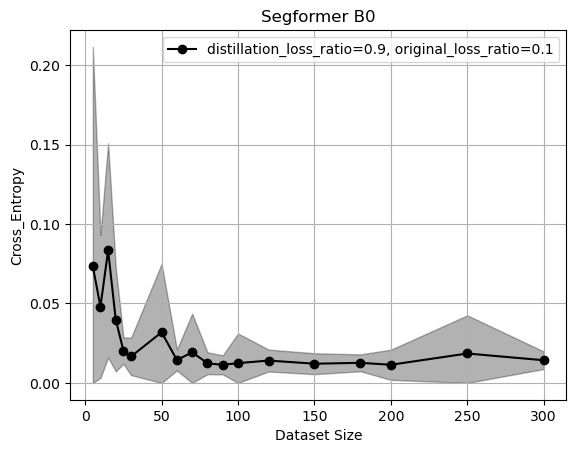

In [2]:
import os
import json

print("train_size size = ", np.array(train_sizes).size)
print("mean_val_losses size = ", np.array(mean_val_losses).size)
print("std_val_losses size = ", np.array(std_val_losses).size)
print("train_size = ", train_sizes)
print("mean_val_losses = ", mean_val_losses)
print("std_val_losses = ", std_val_losses)

results_dir = os.path.join(os.getcwd(), 'TrainingRecords', 'results_KD_segformer_0616')
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

results = {
    "train_sizes": train_sizes,
    "mean_val_losses": mean_val_losses,
    "std_val_losses": std_val_losses
}
json_path = os.path.join(results_dir, f"results_KD_segformer_0616_{int(teacher_ratio*100)}.json")
with open(json_path, 'w') as json_file:
    json.dump(results, json_file, indent=4)

plt.figure()
plt.plot(train_sizes, mean_val_losses, marker='o', color='black', label=f'distillation_loss_ratio={teacher_ratio}, original_loss_ratio={round(1-teacher_ratio, 2)}')
plt.fill_between(train_sizes, np.maximum(0, np.array(mean_val_losses) - np.array(std_val_losses)), 
                 np.array(mean_val_losses) + np.array(std_val_losses), color='black', alpha=0.3)
plt.title('Segformer B0')
plt.xlabel('Dataset Size')
plt.ylabel('Cross_Entropy')
plt.grid(True)
plt.legend()
plt.savefig(os.path.join(results_dir, f"results_KD_segformer_0616_{int(teacher_ratio*100)}.png"))

plt.show()